<a href="https://colab.research.google.com/github/aashmore/CV/blob/main/Anthony/Equivariant%20layers%203%2B1d.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Installing NetKet

On Google Colab, use the following command to install the required packages.

In [1]:
pip install --upgrade matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 80.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.3/98.3 kB 11.7 MB/s eta 0:00:00
  Attempting uninstall: pyparsing
    Found existing installation: pyparsing 3.1.0
    Uninstalling pyparsing-3.1.0:
      Successfully uninstalled pyparsing-3.1.0
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.7.1
    Uninstalling matplotlib-3.7.1:
      Successfully uninstalled matplotlib-3.7.1


In [2]:
!pip install --upgrade "jax[cuda]" -f https://storage.googleapis.com/jax-releases/jax_releases.html

Looking in links: https://storage.googleapis.com/jax-releases/jax_releases.html


In [ ]:
!pip install --upgrade netket

We also want to make sure that Jax is running on the CPU. It benefits from a GPU only for large numbers of spins.

In [ ]:
import os
os.environ["JAX_PLATFORM_NAME"] = "gpu"
%env XLA_PYTHON_CLIENT_PREALLOCATE=false

In [ ]:
!nvidia-smi -L

In [ ]:
# set up cloud TPU
# import jax.tools.colab_tpu
# jax.tools.colab_tpu.setup_tpu()

import jax
from jax.lib import xla_bridge
print(xla_bridge.get_backend().platform)
print(jax.devices())

Check the install was successful and print the version.

In [6]:
import netket as nk
print(f"NetKet version: {nk.__version__}")

import functools
from netket.operator.spin import sigmax, sigmaz
import flax.linen as nn
import jax.numpy as jnp

NetKet version: 3.8


## Defining the Hamiltonian

Start by defining the Hamiltonian of the system. We first define the degrees of freedom we are dealing with by specifying the Hilbert space of the problem. We start with an example of $N\times N$ spins on a lattice.

In [7]:
# size of lattice
nx = 3
ny = 3
nz = 3

graph = nk.graph.Lattice(basis_vectors=[[0,0,1],[0,1,0],[1,0,0]],
                         site_offsets = [[1/2,0,0],[0,1/2,0],[0,0,1/2]],
                         extent = [nz,ny,nx],
                         pbc=True
                        )

# graph = nk.graph.Hypercube(length=L, n_dim=2, pbc=True)

print("Number of edges in graph:",graph.n_edges)
print("Number of nodes in graph:",graph.n_nodes)

print("List of edges in graph:",graph.edges())

# graph.draw()

# number of nodes in graph
N = graph.n_nodes

# ZN def
ZN = 3
num_spin = (ZN - 1) / 2

hi = nk.hilbert.Spin(s=num_spin)**(N)

Number of edges in graph: 1500
Number of nodes in graph: 375
List of edges in graph: [(212, 297), (84, 148), (0, 5), (40, 41), (270, 274), (343, 344), (321, 325), (73, 74), (33, 38), (303, 307), (150, 214), (354, 358), (66, 71), (106, 107), (317, 327), (336, 340), (7, 21), (47, 57), (51, 356), (99, 104), (366, 368), (369, 373), (40, 54), (343, 357), (230, 300), (165, 170), (263, 333), (106, 120), (32, 91), (198, 203), (296, 366), (207, 208), (65, 124), (240, 241), (172, 186), (98, 157), (3, 5), (20, 94), (273, 274), (31, 332), (131, 190), (36, 38), (247, 258), (53, 127), (306, 307), (64, 365), (24, 329), (164, 223), (69, 71), (280, 291), (86, 160), (339, 340), (372, 374), (197, 256), (10, 21), (102, 104), (19, 335), (313, 324), (119, 193), (43, 54), (135, 137), (52, 368), (346, 357), (152, 226), (76, 87), (168, 170), (180, 181), (185, 259), (38, 97), (301, 327), (213, 214), (218, 292), (71, 130), (31, 57), (42, 332), (230, 303), (246, 247), (104, 163), (263, 336), (9, 11), (80, 214), (

In [8]:
# list of positions of the sites / nodes
pos_sites = [[0.+i,0.+j,0.+k] for k in range (0,nz) for j in range (0,ny) for i in range(0,nx)]

# generate a list of the positions of the links in x, y and z directions
x_pos_links = [[.5+i,0.+j,0.+k] for k in range (0,nz) for j in range (0,ny) for i in range(0,nx)]
y_pos_links = [[.0+i,0.5+j,0.+k] for k in range (0,nz) for j in range (0,ny) for i in range(0,nx)]
z_pos_links = [[.0+i,0.+j,0.5+k] for k in range (0,nz) for j in range (0,ny) for i in range(0,nx)]

# get list of ids for links in x, y and z directions
x_id_links = [graph.id_from_position(pos) for pos in x_pos_links]
x_id_links_jnp = jnp.asarray([graph.id_from_position(pos) for pos in x_pos_links])
y_id_links = [graph.id_from_position(pos) for pos in y_pos_links]
y_id_links_jnp = jnp.asarray([graph.id_from_position(pos) for pos in y_pos_links])
z_id_links = [graph.id_from_position(pos) for pos in z_pos_links]
z_id_links_jnp = jnp.asarray([graph.id_from_position(pos) for pos in z_pos_links])

# generate a list of the positions of the links associated to each site
# written for 2d at the moment, but simple to extend to higher dimensions
site_pos_links = [[[0.5+i,0.+j,0.+k],[0.+i,0.5+j,0.+k],[0.+i,0.+j,0.5+k],[(-0.5+i) % nx,0.+j,0.+k],[0.+i,(-0.5+j) % ny,0.+k],[0.+i,0.+j,(-0.5+k) % nz]] for k in range (0,nz) for j in range (0,ny) for i in range(0,nx)]

# get list of ids for links that are connected to each site
# has form [x, y, z, -x, -y, -z]
site_id_links = [tuple(graph.id_from_position(pos)) for pos in site_pos_links]
site_id_links_jnp = jnp.asarray([list(graph.id_from_position(pos)) for pos in site_pos_links])

# generate a list of the positions of the links that form each 1-plaquette
# the position in the list corresponds to the node that the plaquette starts from
plaqs_pos_links_xy = [[[0.5+i,0.+j,0.+k],[(1.+i) % nx,0.5+j,0.+k],[0.5+i,(1.+j) % ny,0.+k],[0.+i,0.5+j,0.+k]] for k in range (0,nz) for j in range (0,ny) for i in range(0,nx)]

# generate a list of the positions of the links that form each 1-plaquette
# the position in the list corresponds to the node that the plaquette starts from
plaqs_pos_links_yz = [[[0.+i, 0.5+j, 0.+k],[0.+i, (1.+j) % ny, .5+k],[0.+i, .5 + j, (1.+k) % nz],[0.+i, 0.+j, 0.5+k]] for k in range (0,nz) for j in range (0,ny) for i in range(0,nx)]

# generate a list of the positions of the links that form each 1-plaquette
# the position in the list corresponds to the node that the plaquette starts from
plaqs_pos_links_zx = [[[0.+i, 0.+j, 0.5+k],[0.5+i, 0.+j, (1.+k) % nz],[(1.+i) % nx, 0. + j, .5+k],[.5+i, 0.+j, 0.+k]] for k in range (0,nz) for j in range (0,ny) for i in range(0,nx)]

# get list of ids for plaqs in xy, yz and zx directions
plaqs_id_links_xy = [graph.id_from_position(pos) for pos in plaqs_pos_links_xy]
plaqs_id_links_xy_jnp = jnp.asarray([graph.id_from_position(pos) for pos in plaqs_pos_links_xy])
plaqs_id_links_yz = [graph.id_from_position(pos) for pos in plaqs_pos_links_yz]
plaqs_id_links_yz_jnp = jnp.asarray([graph.id_from_position(pos) for pos in plaqs_pos_links_yz])
plaqs_id_links_zx = [graph.id_from_position(pos) for pos in plaqs_pos_links_zx]
plaqs_id_links_zx_jnp = jnp.asarray([graph.id_from_position(pos) for pos in plaqs_pos_links_zx])

# list of ids for all plaqs - used for Hamiltonian
plaqs_id_links = plaqs_id_links_xy + plaqs_id_links_yz + plaqs_id_links_zx

Now important Jax and generate two random states.

In [9]:
# "JAX will preallocate 75% of the total GPU memory when the first JAX operation is run"
hi.random_state(key=jax.random.PRNGKey(0), size=1)

[gpu(id=0)]


Array([[-2., -2., -2., -2.,  0., -2.,  2., -2., -2., -2.,  0.,  2., -2.,
         0.,  0.,  2., -2.,  0.,  2., -2.,  0., -2.,  2.,  0.,  0.,  2.,
         0., -2., -2.,  0.,  0.,  0.,  2.,  2., -2.,  0., -2.,  0., -2.,
        -2.,  0.,  2.,  2.,  2.,  2.,  0.,  2., -2., -2.,  2., -2.,  2.,
        -2., -2.,  0.,  2.,  0., -2., -2., -2.,  0.,  0.,  2.,  2.,  2.,
         2.,  2., -2.,  2., -2.,  2.,  0.,  2., -2.,  0., -2.,  0.,  0.,
         0.,  0., -2., -2.,  2.,  0.,  2.,  0.,  2.,  2., -2.,  0., -2.,
         0.,  0.,  0., -2.,  2.,  0.,  0., -2.,  2., -2., -2., -2., -2.,
        -2.,  0., -2.,  0.,  0., -2.,  2., -2.,  0.,  2.,  2., -2.,  2.,
         2.,  2.,  0.,  0.,  2.,  2.,  0., -2.,  2., -2., -2.,  0.,  0.,
         2.,  2., -2., -2.,  2.,  2.,  0.,  0., -2.,  2.,  2.,  0.,  2.,
         2., -2., -2., -2.,  2.,  0.,  0., -2.,  0., -2.,  2.,  0., -2.,
         2.,  2.,  2., -2., -2.,  2., -2.,  0.,  0.,  0., -2.,  2., -2.,
        -2.,  2.,  0.,  0., -2.,  2., -2., -2.,  0.

Define some new local operators (identity matrix, clock and shift).

In [10]:
from netket.operator.spin import sigmax, sigmaz

from scipy import sparse as _sparse

from netket.utils.types import DType as _DType

from netket.hilbert import AbstractHilbert as _AbstractHilbert

from netket.operator._local_operator import LocalOperator as _LocalOperator


def id_mat(
    hilbert: _AbstractHilbert, site: int, dtype: _DType = float
) -> _LocalOperator:
    """
    Builds the identity matrix operator acting on the `site`-th of the Hilbert
    space `hilbert`.

    If `hilbert` is a non-Spin space of local dimension M, it is considered
    as a (M-1)/2 - spin space.

    :param hilbert: The hilbert space
    :param site: the site on which this operator acts
    :return: a nk.operator.LocalOperator
    """
    import numpy as np

    N = hilbert.size_at_index(site)

    D = [1 for a in np.arange(1, N+1)]
    mat = np.diag(D)
    mat = _sparse.coo_matrix(mat)
    return _LocalOperator(hilbert, mat, [site], dtype=dtype)

Clock and shift operators match with Q and P from 2008.00882.

In [11]:
# def clock(d):
#     # Define the dth root of unity
#     omega = np.exp(2j * np.pi / d)

#     # Generate the clock matrix
#     clock = np.diag([omega**i for i in range(d)])

#     return clock

# def shift(d):

#     # Generate the shift matrix
#     shift = np.zeros((d, d))
#     shift[0, -1] = 1
#     shift[1:, :-1] = np.eye(d - 1)

#     return shift

def shift(
    hilbert: _AbstractHilbert, site: int, dtype: _DType = float
) -> _LocalOperator:
    """
    Builds the shift operator acting on the `site`-th of the Hilbert
    space `hilbert`.

    If `hilbert` is a non-Spin space of local dimension M, it is considered
    as a (M-1)/2 - spin space.

    :param hilbert: The hilbert space
    :param site: the site on which this operator acts
    :return: a nk.operator.LocalOperator
    """
    import numpy as np

    N = hilbert.size_at_index(site)

    mat = np.zeros((N, N))
    mat[0, -1] = 1
    mat[1:, :-1] = np.eye(N - 1)
    mat = _sparse.coo_matrix(mat)
    return _LocalOperator(hilbert, mat, [site], dtype=dtype)

def clock(
    hilbert: _AbstractHilbert, site: int, dtype: _DType = complex
) -> _LocalOperator:
    """
    Builds the clock operator acting on the `site`-th of the Hilbert
    space `hilbert`.

    If `hilbert` is a non-Spin space of local dimension M, it is considered
    as a (M-1)/2 - spin space.

    :param hilbert: The hilbert space
    :param site: the site on which this operator acts
    :return: a nk.operator.LocalOperator
    """
    import numpy as np
    import netket.jax as nkjax

    if not nkjax.is_complex_dtype(dtype):
        import jax.numpy as jnp
        import warnings

        old_dtype = dtype
        dtype = jnp.promote_types(complex, old_dtype)
        warnings.warn(
            np.ComplexWarning(
                f"A complex dtype is required (dtype={old_dtype} specified). "
                f"Promoting to dtype={dtype}."
            )
        )

    N = hilbert.size_at_index(site)
    # Define the N-th root of unity
    omega = np.exp(2j * np.pi / N)

    mat = np.diag([omega**i for i in range(N)])
    mat = _sparse.coo_matrix(mat)
    return _LocalOperator(hilbert, mat, [site], dtype=dtype)

New Hamiltonian for $\mathbb{Z}_N$ gauge theory (from 2008.00882). Currently doesn't have the constant shift terms.

Note that NetKet doesn't like putting a minus sign in front of an adjoint operator, but is fine with it outside of the brackets.

In [63]:
# g = 2.

# H = - (1 / (2 * g**2)) * sum([(clock(hilbert=hi, site=i).H * clock(hilbert=hi, site=j).H *
#          clock(hilbert=hi, site=k) * clock(hilbert=hi, site=l) + clock(hilbert=hi, site=l).H * clock(hilbert=hi, site=k).H *
#          clock(hilbert=hi, site=j) * clock(hilbert=hi, site=i)) for (i,j,k,l) in plaqs_id_links])

# H = H - ((g**2) / 2) * sum([(shift(hilbert=hi, site=i) + shift(hilbert=hi, site=i).H) for i in range(N)])

Now with shift terms (moves energy by $+L^2 (g^2 + 1/g^2)$).

In [12]:
g = 2.

H = - (1 / (2 * g**2)) * sum([(- 2 * id_mat(hilbert=hi, site=i)*id_mat(hilbert=hi, site=j)*
            id_mat(hilbert=hi, site=k)*id_mat(hilbert=hi, site=l) + clock(hilbert=hi, site=i).H * clock(hilbert=hi, site=j).H *
         clock(hilbert=hi, site=k) * clock(hilbert=hi, site=l) + clock(hilbert=hi, site=l).H * clock(hilbert=hi, site=k).H *
         clock(hilbert=hi, site=j) * clock(hilbert=hi, site=i)) for (i,j,k,l) in plaqs_id_links])

H = H - ((g**2) / 2) * sum([(- 2 * id_mat(hilbert=hi, site=i) + shift(hilbert=hi, site=i) + shift(hilbert=hi, site=i).H) for i in range(N)])

$\mathbb{Z}_N$ gauge operator. Define $\Theta_x = P_{x,\mu} P_{x,\nu} P^\dagger_{x-\mu,\mu} P^\dagger_{x-\nu,\nu}$. The gauge invariance condition is then $\Theta_x |\Psi\rangle = \pm |\Psi\rangle$ with the same choice of sign for all $x$. We can then impose this as a positive definite condition as $(\Theta-1)(\Theta^\dagger - 1) = $ on gauge invariant states.

In [13]:
# should give +-L^2
gauge = sum([shift(hilbert=hi, site=i)*shift(hilbert=hi, site=j)*shift(hilbert=hi, site=k)*(shift(hilbert=hi, site=l).H)*(shift(hilbert=hi, site=m).H)*(shift(hilbert=hi, site=n).H) for (i,j,k,l,m,n) in site_id_links])

# should give 0
gauge_zero = sum([(shift(hilbert=hi, site=i)*shift(hilbert=hi, site=j)*shift(hilbert=hi, site=k)*(shift(hilbert=hi, site=l).H)*(shift(hilbert=hi, site=m).H)*(shift(hilbert=hi, site=n).H)-id_mat(hilbert=hi, site=i)*id_mat(hilbert=hi, site=j)*
            id_mat(hilbert=hi, site=k)*id_mat(hilbert=hi, site=l)*id_mat(hilbert=hi, site=m)*id_mat(hilbert=hi, site=n))*(shift(hilbert=hi, site=n)*shift(hilbert=hi, site=m)*shift(hilbert=hi, site=l)*(shift(hilbert=hi, site=k).H)*(shift(hilbert=hi, site=j).H)*(shift(hilbert=hi, site=i).H)
            -id_mat(hilbert=hi, site=i)*id_mat(hilbert=hi, site=j)*id_mat(hilbert=hi, site=k)*id_mat(hilbert=hi, site=l)*id_mat(hilbert=hi, site=m)*id_mat(hilbert=hi, site=n)) for (i,j,k,l,m,n) in site_id_links])

## Exact diagonalisation

We can start by trying exact diagonalisation. This works by converting the Hamiltonian operator in a sparse matrix of size $2^{N^2} \times 2^{N^2} = 1024 \times 1024$. This is just a standard scipy sparse matrix, so we can use any (sparse) matrix diagonalisation routine to find the eigensystem. For example, we can find the two lowest eigenstates via:

In [ ]:
# eig_vals, eig_vecs = nk.exact.lanczos_ed(H, k=1, compute_eigenvectors=True)

# print("Eigenvalues with sparse solver:", eig_vals)

# E_gs = eig_vals[0]

# print("Approx energy per site:", [E/(nx * ny) for E in  eig_vals_penalty])

# eig_vals_penalty, eig_vecs_penalty = nk.exact.lanczos_ed(H_penalty, k=1, compute_eigenvectors=True)

# print("Eigenvalues with gauge penalty with sparse solver:", eig_vals_penalty)

# print("Approx energy per site:", [(E - penalty * nx * ny)/(nx * ny) for E in  eig_vals_penalty])

# E_gs_penalty = eig_vals_penalty[0]

## Neural network quantum state

In [14]:
# numerical operations in the model should always use jax.numpy
# instead of numpy because jax supports computing derivatives.
# If you want to better understand the difference between the two, check
# https://flax.readthedocs.io/en/latest/notebooks/jax_for_the_impatient.html
import jax.numpy as jnp

# Flax is a framework to define models using jax
import flax

# we refer to `flax.linen` as `nn`. It's a repository of
# layers, initializers and nonlinear functions.
import flax.linen as nn

from typing import Any, Callable, Sequence
from jax import lax, random
from flax.core import freeze, unfreeze

## 1. Functions for converting from spins to $\mathbb{Z}_N$ phases.

Functions to convert a spin state to $\mathbb{Z}_N$ phases. By working with the phases, this should generalise more easily to non-abelian groups.

In [15]:
# function to convert a state, given by an array of spins, to Z_N elements
# e.g. spins (1,-1) -> (1,0), or (1,0,-1) -> (2,1,0)
# and then take exp(..2 i pi / N) to get the Z_N phase
# for what follows, we assume that the phases are directed such that the
# non-daggered phases are those on links leading away from the origin
@jax.jit
def spins_to_links(state, N):
    links = (state + (N-1.)) / 2
    links = jnp.exp(2 * jnp.pi * 1j * links / N)
    return links


# single state is an array
x = hi.random_state(key=jax.random.PRNGKey(0))
print(x)
print(spins_to_links(x, 2))

[-2. -2. -2. -2.  0. -2.  2. -2. -2. -2.  0.  2. -2.  0.  0.  2. -2.  0.
  2. -2.  0. -2.  2.  0.  0.  2.  0. -2. -2.  0.  0.  0.  2.  2. -2.  0.
 -2.  0. -2. -2.  0.  2.  2.  2.  2.  0.  2. -2. -2.  2. -2.  2. -2. -2.
  0.  2.  0. -2. -2. -2.  0.  0.  2.  2.  2.  2.  2. -2.  2. -2.  2.  0.
  2. -2.  0. -2.  0.  0.  0.  0. -2. -2.  2.  0.  2.  0.  2.  2. -2.  0.
 -2.  0.  0.  0. -2.  2.  0.  0. -2.  2. -2. -2. -2. -2. -2.  0. -2.  0.
  0. -2.  2. -2.  0.  2.  2. -2.  2.  2.  2.  0.  0.  2.  2.  0. -2.  2.
 -2. -2.  0.  0.  2.  2. -2. -2.  2.  2.  0.  0. -2.  2.  2.  0.  2.  2.
 -2. -2. -2.  2.  0.  0. -2.  0. -2.  2.  0. -2.  2.  2.  2. -2. -2.  2.
 -2.  0.  0.  0. -2.  2. -2. -2.  2.  0.  0. -2.  2. -2. -2.  0.  2.  0.
  2. -2.  2.  0. -2. -2.  2.  0.  2. -2.  0.  2.  2.  2.  2.  0.  2.  0.
  2.  0.  2.  0.  2. -2.  0. -2.  0.  2.  2.  2.  0.  0.  0.  2.  2.  2.
  0.  0.  0.  2.  2.  2.  2.  0. -2.  2. -2.  0.  0.  2. -2.  2. -2. -2.
 -2.  2. -2.  2.  2.  0.  0.  0.  0. -2. -2.  2. -2

Function to convert a batch of spin states to $\mathbb{Z}_N$ phases.

In [16]:
# use vmap to batch generation of Z_N phases over an array of states
@jax.jit
def spins_to_links_batched(state_batched, N):
    return jax.vmap(spins_to_links, in_axes=(0,None), out_axes=0)(state_batched, N)


# when you specify the size, you get a array of arrays
x = hi.random_state(key=jax.random.PRNGKey(0), size=1)
print(x)
print(spins_to_links_batched(x, 2))

[[-2. -2. -2. -2.  0. -2.  2. -2. -2. -2.  0.  2. -2.  0.  0.  2. -2.  0.
   2. -2.  0. -2.  2.  0.  0.  2.  0. -2. -2.  0.  0.  0.  2.  2. -2.  0.
  -2.  0. -2. -2.  0.  2.  2.  2.  2.  0.  2. -2. -2.  2. -2.  2. -2. -2.
   0.  2.  0. -2. -2. -2.  0.  0.  2.  2.  2.  2.  2. -2.  2. -2.  2.  0.
   2. -2.  0. -2.  0.  0.  0.  0. -2. -2.  2.  0.  2.  0.  2.  2. -2.  0.
  -2.  0.  0.  0. -2.  2.  0.  0. -2.  2. -2. -2. -2. -2. -2.  0. -2.  0.
   0. -2.  2. -2.  0.  2.  2. -2.  2.  2.  2.  0.  0.  2.  2.  0. -2.  2.
  -2. -2.  0.  0.  2.  2. -2. -2.  2.  2.  0.  0. -2.  2.  2.  0.  2.  2.
  -2. -2. -2.  2.  0.  0. -2.  0. -2.  2.  0. -2.  2.  2.  2. -2. -2.  2.
  -2.  0.  0.  0. -2.  2. -2. -2.  2.  0.  0. -2.  2. -2. -2.  0.  2.  0.
   2. -2.  2.  0. -2. -2.  2.  0.  2. -2.  0.  2.  2.  2.  2.  0.  2.  0.
   2.  0.  2.  0.  2. -2.  0. -2.  0.  2.  2.  2.  0.  0.  0.  2.  2.  2.
   0.  0.  0.  2.  2.  2.  2.  0. -2.  2. -2.  0.  0.  2. -2.  2. -2. -2.
  -2.  2. -2.  2.  2.  0.  0.  0.  0. 

# 2. Functions to converting from vector of links to tensor

In [17]:
# function to convert a list of the link variables, indexed by the edge labels on the graph
# to an (dim,nx,ny,nz) tensor
# the first index labels whether you are picking the x, y or z links
# the second and third index label the (x,y,z) coordinates of the associated node
@jax.jit
def links_to_tensor(links):
    x_links = links[x_id_links_jnp]
    y_links = links[y_id_links_jnp]
    z_links = links[z_id_links_jnp]
    xyz_links = jnp.stack((x_links, y_links,z_links), axis=0)
    return jnp.reshape(xyz_links,(3, nx, ny, nz), order="F")

x = jnp.asarray(range(2 * nx * ny * nz))
print(x)
print(links_to_tensor(x))
print(links_to_tensor(x).shape)
print(links_to_tensor(x)[1,0,0,1])
print(links_to_tensor(x)[0,0,0,1])

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241 242 243 244 245 24

In [18]:
# function to convert a list of the link variables, indexed by the edge labels on the graph
# to an (dim,nx,ny) tensor
# the first index labels whether you are picking the x or the y links
# the second and third index label the (x,y) coordinates of the associated node
@jax.jit
def links_to_tensor_batched(links_batched):
    return jax.vmap(links_to_tensor, in_axes=(0), out_axes=0)(links_batched)

x = jnp.asarray([jnp.asarray(range(2 * nx * ny * nz))])
print(x)
print(links_to_tensor_batched(x))
print(links_to_tensor_batched(x).shape)
print(links_to_tensor_batched(x)[0,1,0,1])

[[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
   18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
   36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
   54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
   72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
   90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
  108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
  126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
  144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
  162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
  180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
  198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
  216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
  234 235 236 237 238 239 240 241 242 

New Flax layer which converts a batch of vectors of spin states and returns a batch of $\mathbb{Z}_N$ phases.

Input: (n_batch, spin_states_vector)
Output: (n_batch, 0 or 1, x coord, y coord)

The spin_states_vector links are numbered according to the Netket graph.

In the output, we convert this to a tensor, with 0 or 1 labelling whether we are looking at the x links or the y links, and the x and y coords labelling the node associated to those links (links leave node in positive x or y direction).

In [19]:
# A Flax model must be a class subclassing `nn.Module`
# The most compact way to define the model is this.
# The __call__(self, x) function should take as
# input a batch of states shape = (n_batch, spin_states_vector)
# and should return (n_batch, 0 or 1 or 2, x coord, y coord, z coord)
# where the coords refer to the node to which the links are associated
class ZN_to_Phase(nn.Module):

    # You can define attributes at the module-level
    # with a default. This allows you to easily change
    # some hyper-parameter without redefining the whole
    # flax module.
    N: int

    @nn.compact
    def __call__(self, x):

        links_vector_batch = spins_to_links_batched(x, self.N)
        links_tensor_batch = links_to_tensor_batched(links_vector_batch)

        # return the output
        return links_tensor_batch

# Create an instance of the model.
model_1 = ZN_to_Phase(N=2)

# Create the local sampler on the hilbert space
#sampler = nk.sampler.MetropolisLocal(hi)

# Construct the variational state using the model and the sampler above.
# n_samples specifies how many samples should be used to compute expectation
# values.
#vstate = nk.vqs.MCState(sampler, model, n_samples=1000)

#vstate.n_parameters

x = hi.random_state(key=jax.random.PRNGKey(0), size=1)

key1, key2 = random.split(random.PRNGKey(0))
params_1 = model_1.init(key1, x) # Initialization call
# jax.tree_util.tree_map(lambda x: x.shape, params) # Checking output shapes

print(x)
print(links_to_tensor_batched(spins_to_links_batched(x, 2)))
print(model_1.apply(params_1, x))

[[-2. -2. -2. -2.  0. -2.  2. -2. -2. -2.  0.  2. -2.  0.  0.  2. -2.  0.
   2. -2.  0. -2.  2.  0.  0.  2.  0. -2. -2.  0.  0.  0.  2.  2. -2.  0.
  -2.  0. -2. -2.  0.  2.  2.  2.  2.  0.  2. -2. -2.  2. -2.  2. -2. -2.
   0.  2.  0. -2. -2. -2.  0.  0.  2.  2.  2.  2.  2. -2.  2. -2.  2.  0.
   2. -2.  0. -2.  0.  0.  0.  0. -2. -2.  2.  0.  2.  0.  2.  2. -2.  0.
  -2.  0.  0.  0. -2.  2.  0.  0. -2.  2. -2. -2. -2. -2. -2.  0. -2.  0.
   0. -2.  2. -2.  0.  2.  2. -2.  2.  2.  2.  0.  0.  2.  2.  0. -2.  2.
  -2. -2.  0.  0.  2.  2. -2. -2.  2.  2.  0.  0. -2.  2.  2.  0.  2.  2.
  -2. -2. -2.  2.  0.  0. -2.  0. -2.  2.  0. -2.  2.  2.  2. -2. -2.  2.
  -2.  0.  0.  0. -2.  2. -2. -2.  2.  0.  0. -2.  2. -2. -2.  0.  2.  0.
   2. -2.  2.  0. -2. -2.  2.  0.  2. -2.  0.  2.  2.  2.  2.  0.  2.  0.
   2.  0.  2.  0.  2. -2.  0. -2.  0.  2.  2.  2.  0.  0.  0.  2.  2.  2.
   0.  0.  0.  2.  2.  2.  2.  0. -2.  2. -2.  0.  0.  2. -2.  2. -2. -2.
  -2.  2. -2.  2.  2.  0.  0.  0.  0. 

## 3. Functions for computing plaquette variables

In [20]:
# calculate all xy plaquettes
@jax.jit
def tensor_links_to_plaqs_xy(tensor_links):
    # mu = xhat, nu = yhat
    # U_x,mu - select x links
    U_x_mu = tensor_links[0]
    # U_x,nu - select y links
    U_x_nu = tensor_links[1]
    # U_x+mu,nu
    U_x_mu_nu = jnp.roll(U_x_nu, (-1, 0, 0), axis=(0,1,2))
    # U_x+nu,mu
    U_x_nu_mu = jnp.roll(U_x_mu, (0, -1, 0), axis=(0,1,2))
    # plaq_x = U_x,mu * U_x+mu,nu * dag(U_x+nu,mu) * dag(U_x,nu)
    return jnp.multiply(jnp.multiply(U_x_mu, U_x_mu_nu), jnp.multiply(jnp.conj(U_x_nu_mu), jnp.conj(U_x_nu)))

# calculate all xy plaquettes
@jax.jit
def tensor_links_to_plaqs_yz(tensor_links):
    # mu = yhat, nu = zhat
    # U_x,mu - select y links
    U_x_mu = tensor_links[1]
    # U_x,nu - select z links
    U_x_nu = tensor_links[2]
    # U_x+mu,nu
    U_x_mu_nu = jnp.roll(U_x_nu, (0, -1, 0), axis=(0,1,2))
    # U_x+nu,mu
    U_x_nu_mu = jnp.roll(U_x_mu, (0, 0, -1), axis=(0,1,2))
    # plaq_x = U_x,mu * U_x+mu,nu * dag(U_x+nu,mu) * dag(U_x,nu)
    return jnp.multiply(jnp.multiply(U_x_mu, U_x_mu_nu), jnp.multiply(jnp.conj(U_x_nu_mu), jnp.conj(U_x_nu)))

# calculate all xy plaquettes
@jax.jit
def tensor_links_to_plaqs_zx(tensor_links):
    # mu = zhat, nu = xhat
    # U_x,mu - select x links
    U_x_mu = tensor_links[2]
    # U_x,nu - select y links
    U_x_nu = tensor_links[0]
    # U_x+mu,nu
    U_x_mu_nu = jnp.roll(U_x_nu, (0, 0, -1), axis=(0,1,2))
    # U_x+nu,mu
    U_x_nu_mu = jnp.roll(U_x_mu, (-1, 0, 0), axis=(0,1,2))
    # plaq_x = U_x,mu * U_x+mu,nu * dag(U_x+nu,mu) * dag(U_x,nu)
    return jnp.multiply(jnp.multiply(U_x_mu, U_x_mu_nu), jnp.multiply(jnp.conj(U_x_nu_mu), jnp.conj(U_x_nu)))


# example
x = jnp.asarray(range(2 * nx * ny * nz))
print(x)
print(links_to_tensor(x))

tensor_links_to_plaqs_xy(links_to_tensor(x))[1,1]

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241 242 243 244 245 24

Array([    248292,   91581192,  893666592, 3646635876, 3844124001], dtype=int64)

In [21]:
# use vmap to batch generation of plaqs over an array of states
@jax.jit
def tensor_links_to_plaqs_xy_batched(tensor_links_batched):
    return jax.vmap(tensor_links_to_plaqs_xy, in_axes=(0), out_axes=0)(tensor_links_batched)

# use vmap to batch generation of plaqs over an array of states
@jax.jit
def tensor_links_to_plaqs_yz_batched(tensor_links_batched):
    return jax.vmap(tensor_links_to_plaqs_yz, in_axes=(0), out_axes=0)(tensor_links_batched)

# use vmap to batch generation of plaqs over an array of states
@jax.jit
def tensor_links_to_plaqs_zx_batched(tensor_links_batched):
    return jax.vmap(tensor_links_to_plaqs_zx, in_axes=(0), out_axes=0)(tensor_links_batched)

x = hi.random_state(key=jax.random.PRNGKey(0), size=7)
tensor_links_to_plaqs_xy_batched(links_to_tensor_batched(x)).shape
jnp.expand_dims(tensor_links_to_plaqs_xy_batched(links_to_tensor_batched(x)), axis=1).shape

jnp.concatenate([tensor_links_to_plaqs_xy_batched(links_to_tensor_batched(x)),tensor_links_to_plaqs_xy_batched(links_to_tensor_batched(x))], axis=1).shape

(7, 10, 5, 5)

Flax layer to compute plaquettes from link phases

Input: (n_batch, 0 or 1, x coord, y coord)
Output: (n_batch, channel, x coord, y coord)

Input are link phase variables as a tensor, with 0 or 1 labelling whether they are the x or y links associated to a node at (x coord, y coord).

In the output, we have a batch of plaq tensors with an extra channel index (= 0) so that we can treat it as a $W_{x,i}$ variable with one channel.

In [22]:
# A Flax model must be a class subclassing `nn.Module`
# The most compact way to define the model is this.
# The __call__(self, x) function should take as
# input a batch of link variables x.shape = (n_batch, 0 or 1 or 2, x coord, y coord, z coord)
# and should return a batch of plaqs of shape (n_batch, channels, x coord, y coord, z coord)
class Plaq(nn.Module):

    # You can define attributes at the module-level
    # with a default. This allows you to easily change
    # some hyper-parameter without redefining the whole
    # flax module.

    @nn.compact
    def __call__(self, links):
        # compute plaqs from links
        plaqs_xy = tensor_links_to_plaqs_xy_batched(links)
        plaqs_yz = tensor_links_to_plaqs_yz_batched(links)
        plaqs_zx = tensor_links_to_plaqs_zx_batched(links)

        # convert to a W_i variable by adding a channel index
        plaqs_xy = jnp.expand_dims(plaqs_xy, axis=1)
        plaqs_yz = jnp.expand_dims(plaqs_yz, axis=1)
        plaqs_zx = jnp.expand_dims(plaqs_zx, axis=1)

        # convert to a W_i variable by stacking - the xy, yz or zx plaqs are in the channel index
        W_batch_i_x_y_z = jnp.concatenate([plaqs_xy, plaqs_yz, plaqs_zx], axis=1)

        # return the W_i variables with an extra channel
        return W_batch_i_x_y_z

# Create an instance of the model.
model_2 = Plaq()

# Create the local sampler on the hilbert space
#sampler = nk.sampler.MetropolisLocal(hi)

# Construct the variational state using the model and the sampler above.
# n_samples specifies how many samples should be used to compute expectation
# values.
#vstate = nk.vqs.MCState(sampler, model, n_samples=1000)

#vstate.n_parameters

x = hi.random_state(key=jax.random.PRNGKey(0), size=2)

x = model_1.apply(params_1, x)

print(x.shape)

key1, key2 = random.split(random.PRNGKey(0))
params_2 = model_2.init(key1, x) # Initialization call
#jax.tree_util.tree_map(lambda x: x.shape, params) # Checking output shapes

print(x)
print(model_2.apply(params_2, x))
print(model_2.apply(params_2, x).shape)

(2, 3, 5, 5, 5)
[[[[[ 1.1924881e-08-1.j -4.3711388e-08-1.j  1.1924881e-08-1.j
      1.1924881e-08-1.j -4.3711388e-08-1.j]
    [ 1.1924881e-08-1.j  1.1924881e-08-1.j -4.3711388e-08-1.j
      1.1924881e-08-1.j -4.3711388e-08-1.j]
    [ 1.1924881e-08-1.j  1.1924881e-08-1.j  1.1924881e-08-1.j
     -4.3711388e-08+1.j  1.1924881e-08-1.j]
    [-4.3711388e-08-1.j -4.3711388e-08+1.j  1.1924881e-08-1.j
     -4.3711388e-08+1.j -4.3711388e-08+1.j]
    [-4.3711388e-08+1.j -4.3711388e-08-1.j -4.3711388e-08-1.j
     -4.3711388e-08-1.j  1.1924881e-08-1.j]]

   [[-4.3711388e-08+1.j -4.3711388e-08+1.j -4.3711388e-08+1.j
     -4.3711388e-08+1.j -4.3711388e-08+1.j]
    [-4.3711388e-08-1.j -4.3711388e-08+1.j -4.3711388e-08-1.j
     -4.3711388e-08+1.j -4.3711388e-08-1.j]
    [ 1.1924881e-08-1.j -4.3711388e-08+1.j  1.1924881e-08-1.j
     -4.3711388e-08+1.j -4.3711388e-08-1.j]
    [-4.3711388e-08+1.j  1.1924881e-08-1.j -4.3711388e-08-1.j
     -4.3711388e-08+1.j  1.1924881e-08-1.j]
    [-4.3711388e-08+1.j  1.1

## 4. Functions for shifting plaquette variables

In [23]:
# function which takes in a tensor of plaquette variables and shifts them by a specified amount in x, y or z direction.
# In practice, this means it takes in W_x and returns W_(x + mu)
@jax.jit
def shift_plaqs(plaqs_tensor, mu_x, mu_y, mu_z):
    return jnp.roll(plaqs_tensor, (-mu_x, -mu_y, -mu_z), axis=(0,1,2))

In [24]:
# only works for one *positive* unit of transport at the moment, as you need to multiply all the link variables!
# and the negative shifts are actually a little different!
@jax.jit
def transport_x(plaqs_tensor, links_tensor, mu_x):
    plaqs = shift_plaqs(plaqs_tensor, mu_x, 0, 0)
    return jnp.multiply(jnp.multiply(links_tensor[0], plaqs), jnp.conj(links_tensor[0]))

# only works for one *positive* unit of transport at the moment, as you need to multiply all the link variables!
# and the negative shifts are actually a little different!
@jax.jit
def transport_y(plaqs_tensor, links_tensor, mu_y):
    plaqs = shift_plaqs(plaqs_tensor, 0, mu_y, 0)
    return jnp.multiply(jnp.multiply(links_tensor[1], plaqs), jnp.conj(links_tensor[1]))

# only works for one *positive* unit of transport at the moment, as you need to multiply all the link variables!
# and the negative shifts are actually a little different!
@jax.jit
def transport_z(plaqs_tensor, links_tensor, mu_z):
    plaqs = shift_plaqs(plaqs_tensor, 0, 0, mu_z)
    return jnp.multiply(jnp.multiply(links_tensor[2], plaqs), jnp.conj(links_tensor[2]))

In [25]:
@jax.jit
def transport_x_batched(plaqs_tensor_batch, links_tensor_batch, mu_x):
    return jax.vmap(transport_x, in_axes=(0,0,None), out_axes=0)(plaqs_tensor_batch, links_tensor_batch, mu_x)

@jax.jit
def transport_y_batched(plaqs_tensor_batch, links_tensor_batch, mu_y):
    return jax.vmap(transport_y, in_axes=(0,0,None), out_axes=0)(plaqs_tensor_batch, links_tensor_batch, mu_y)

@jax.jit
def transport_z_batched(plaqs_tensor_batch, links_tensor_batch, mu_z):
    return jax.vmap(transport_z, in_axes=(0,0,None), out_axes=0)(plaqs_tensor_batch, links_tensor_batch, mu_z)

In [26]:
@jax.jit
def transport_x_batched_channel(W_tensor_batch_channel, links_tensor_batch, mu_x):
    return jax.vmap(transport_x_batched, in_axes=(1,None,None), out_axes=1)(W_tensor_batch_channel, links_tensor_batch, mu_x)

@jax.jit
def transport_y_batched_channel(W_tensor_batch_channel, links_tensor_batch, mu_y):
    return jax.vmap(transport_y_batched, in_axes=(1,None,None), out_axes=1)(W_tensor_batch_channel, links_tensor_batch, mu_y)

@jax.jit
def transport_z_batched_channel(W_tensor_batch_channel, links_tensor_batch, mu_z):
    return jax.vmap(transport_z_batched, in_axes=(1,None,None), out_axes=1)(W_tensor_batch_channel, links_tensor_batch, mu_z)

## 5. New LConvBilin layer

Flax layer to compute LConvBilin layer from link phases $U_{x,\mu}$ and locally transforming variables $W_{x,i}$ where $i$ labels the channel.

Input: (n_batch, 0 or 1, x coord, y coord) and (n_batch, i, x coord, y coord)
Output: (n_batch, j, x coord, y coord)

Input are link phase variables as a tensor, with 0 or 1 labelling whether they are the x or y links associated to a node at (x coord, y coord), and the $W_{x,i}$ variables with $i=0,\dots,N_{\text{in}}-1$.

In the output, we have a batch of locally transforming variables $W_{x,j}$ where $j=0,\dots,N_{\text{out}}-1$.

In [27]:
# A Flax model must be a class subclassing `nn.Module`
# The most compact way to define the model is this.
# The __call__(self, x) function should take as
# input a batch of states x.shape = (n_samples, spin_states)
# and should return (n_samples, phases)
class LConvBilin(nn.Module):

    # You can define attributes at the module-level
    # with a default. This allows you to easily change
    # some hyper-parameter without redefining the whole
    # flax module.
    N_out: int

    @nn.compact
    def __call__(self, links, plaqs_i):

        # input is batch of plaq variables with extra i index for one channel
        W_batch_i_x_y_z = plaqs_i

        # consider only positive shifts along lattice axis, as in Vienna group sup. mat.
        W_batch_i_x_p_y_z = transport_x_batched_channel(W_batch_i_x_y_z, links, 1)
        # W_batch_i_x_m_y = transport_x_batched_channel(W_batch_i_x_y, links, -1)
        W_batch_i_x_y_p_z = transport_y_batched_channel(W_batch_i_x_y_z, links, 1)
        # W_batch_i_x_y_m = transport_y_batched_channel(W_batch_i_x_y, links, -1)
        W_batch_i_x_y_z_p = transport_z_batched_channel(W_batch_i_x_y_z, links, 1)

        # combine the transported terms into a single object and then include the sum over k (the convolution)
        # by folding it into the channel label
        W_trans_batch_i_x_y_z = jnp.concatenate([W_batch_i_x_y_z, W_batch_i_x_p_y_z, W_batch_i_x_y_p_z, W_batch_i_x_y_z_p], axis=1)

        # include unit matrix at this point
        # without the unit matrix, you discard the smaller Wilson loops!
        batch_size = W_batch_i_x_y_z.shape[0]
        dim_x = W_batch_i_x_y_z.shape[2]
        dim_y = W_batch_i_x_y_z.shape[3]
        dim_z = W_batch_i_x_y_z.shape[4]
        Id_batch_i_x_y_z = jnp.ones((batch_size,1,dim_x,dim_y,dim_z))

        # add conjugate of W variables to both W and W_trans
        # and the unit matrix
        # doubles the channels
        W_batch_i_x_y_z = jnp.concatenate([W_batch_i_x_y_z, jnp.conj(W_batch_i_x_y_z),Id_batch_i_x_y_z], axis=1)
        W_trans_batch_i_x_y_z = jnp.concatenate([W_trans_batch_i_x_y_z, jnp.conj(W_trans_batch_i_x_y_z), Id_batch_i_x_y_z], axis=1)

        # number of channels in W and W_trans with conjugates included
        W_channels = W_batch_i_x_y_z.shape[1]
        W_trans_channels = W_trans_batch_i_x_y_z.shape[1]

        alpha = self.param('alpha', nn.initializers.normal(), (self.N_out, W_channels, W_trans_channels), jnp.complex64)

        out = jnp.einsum('ijk, bjxyz, bkxyz -> bixyz', alpha, W_batch_i_x_y_z, W_trans_batch_i_x_y_z, optimize='optimal')

        # return the output
        return out

# Create an instance of the model.
model_3 = LConvBilin(N_out=7)


x = hi.random_state(key=jax.random.PRNGKey(0), size=100)

links = model_1.apply(params_1, x)

plaqs = model_2.apply(params_2, links)

print(x.shape)

key1, key2 = random.split(random.PRNGKey(0))
params_3 = model_3.init(key1, links, plaqs) # Initialization call
#jax.tree_util.tree_map(lambda x: x.shape, params) # Checking output shapes

from jax import random

# a1 = jax.random.uniform(key1, shape=(3, 2, 10))
# a2 = jax.random.uniform(key1, shape=(6,2,3,3))
# a3 = jax.random.uniform(key1, shape=(6,10,3,3))

# path_info = jnp.einsum_path('ijk, bjxy, bkxy -> bixy', a1, a2, a3, optimize='optimal')
# print(path_info)

print(x)
print(model_3.apply(params_3, links, plaqs).shape)

(100, 375)
[[ 0.  0.  2. ... -2.  2. -2.]
 [ 2. -2.  2. ...  2.  0.  0.]
 [-2. -2.  2. ...  2. -2.  2.]
 ...
 [ 0.  0. -2. ...  2.  0.  2.]
 [ 0.  2.  0. ... -2.  2. -2.]
 [-2.  0. -2. ...  2.  0.  2.]]
(100, 7, 5, 5, 5)


## 6. Flax model that uses the LConvBilin layers followed by a dense layer and relu

In [28]:
# A Flax model must be a class subclassing `nn.Module`
# The most compact way to define the model is this.
# The __call__(self, x) function should take as
# input a batch of states shape = (n_batch, spin_states_vector)
# and should return (n_batch, 0 or 1, x coord, y coord)
# where the coords refer to the node to which the links are associated
class MultiLConvBilin(nn.Module):

    # You can define attributes at the module-level
    # with a default. This allows you to easily change
    # some hyper-parameter without redefining the whole
    # flax module.
    # corresponds to N of Z_N
    N: int
    N_out: Sequence[int]
    features: int

    @nn.compact
    def __call__(self, x):

        links = ZN_to_Phase(self.N)(x)
        W_i_x_y_z = Plaq()(links)

        for i in range(len(self.N_out)):
            W_i_x_y_z = LConvBilin(self.N_out[i])(links, W_i_x_y_z)

        W_i_x_y_z_flat = W_i_x_y_z.reshape(W_i_x_y_z.shape[0], -1)

        # dense = nn.Dense(features=self.features * W_i_x_y_flat.shape[-1], kernel_init=nn.initializers.normal(), param_dtype=jnp.complex64)
        dense = nn.Dense(features=self.features, kernel_init=nn.initializers.normal(), param_dtype=jnp.complex64)

        # we apply the dense layer to the input
        y = dense(W_i_x_y_z_flat)

        # the non-linearity is a simple ReLu
        y = nn.relu(y)

        # return the output
        return jnp.sum(y, axis=-1)

# Create an instance of the model.
model_5 = MultiLConvBilin(N=2, N_out=(4,5), features=10)

# Create the local sampler on the hilbert space
#sampler = nk.sampler.MetropolisLocal(hi)

# Construct the variational state using the model and the sampler above.
# n_samples specifies how many samples should be used to compute expectation
# values.
#vstate = nk.vqs.MCState(sampler, model, n_samples=1000)

#vstate.n_parameters

x = hi.random_state(key=jax.random.PRNGKey(0), size=7)

key1, key2 = random.split(random.PRNGKey(0))
params_5 = model_5.init(key1, x) # Initialization call
print(jax.tree_util.tree_map(lambda x: x.shape, params_5)) # Checking output shapes

print(model_5.apply(params_5, x))

%timeit model_5.apply(params_5, x)
# very slow!
# %timeit jax.jit(model_5.apply)(params_5, x)

FrozenDict({
    params: {
        Dense_0: {
            bias: (10,),
            kernel: (625, 10),
        },
        LConvBilin_0: {
            alpha: (4, 7, 25),
        },
        LConvBilin_1: {
            alpha: (5, 9, 33),
        },
    },
})
[0.00562566+0.00944807j 0.01203134+0.00626987j 0.01416953+0.00649528j
 0.00499984+0.00129483j 0.00972045+0.00102862j 0.01080763-0.00423907j
 0.01515411+0.00099925j]
19.5 ms ± 2.29 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


# Use new layers to compute ground state

In [29]:
# Create an instance of the model.
# N is the N of Z_N
# N_out is a tuple giving the number of output channels for each LConvBilin layer
# longer tuples generate larger Wilson loops
# features is the number of nodes in the dense layer
model = MultiLConvBilin(N=ZN, N_out=(1,), features=50)

# Create the local sampler on the hilbert space
# https://github.com/orgs/netket/discussions/1384 suggests you should use a large number of chains on a gpu
# the default is 16
# https://github.com/orgs/netket/discussions/694 also suggests that you need a large number of samples per chain
# TODO: understand interplay between these
sampler = nk.sampler.MetropolisLocal(hi, n_chains=64)

# Construct the variational state using the model and the sampler above.
# n_samples specifies how many samples should be used to compute expectation
# values.

# Specify chunk_size in the variational state in order to reduce memory consumption. As we have L^3 sites,
# at every VMC step we will need to evaluate the network for O(N_samples x L^3) different configurations,
# but the memory available on commercial GPUs will not be enough to perform this computation in a single pass. Instead, by
# setting chunk_size NetKet will split the calculation in many smaller sub-calculations
vstate = nk.vqs.MCState(sampler, model, n_samples=1024, chunk_size=1024)

vstate.init_parameters(nn.initializers.normal(stddev=0.01))

# print(vstate.parameters)
print(vstate.n_parameters)

x = hi.random_state(key=jax.random.PRNGKey(0), size=3)


key1, key2 = random.split(random.PRNGKey(0))
params = model.init(key2, x) # Initialization call
jax.tree_util.tree_map(lambda x: x.shape, params) # Checking output shapes

model.apply(params, x)

6475


Array([0.27123877-0.05175004j, 0.16409596+0.03998997j,
       0.13817863+0.01963724j], dtype=complex128)

In [30]:
# Then we create an optimiser from the standard library.
# You can also use optax.
optimizer = nk.optimizer.Sgd(learning_rate=0.01)

# build the optimisation driver
# Notice the use of Stochastic Reconfiguration which considerably improves the optimisation
gs = nk.driver.VMC(H, optimizer, variational_state=vstate, preconditioner=nk.optimizer.SR(diag_shift=0.01))

log = nk.logging.RuntimeLog()

gs.run(n_iter=300, out=log)

ffn_energy = vstate.expect(H)

# error = abs((ffn_energy.mean - E_gs)/E_gs)

# print("Optimised energy and relative error:", ffn_energy,error)

nn_energy = vstate.expect(H).mean
# nn_energy_penalty = vstate.expect(H_penalty).mean
# nn_gauge = vstate.expect(gauge).mean


# print("Optimised energy per site (with gauge penalty):", (nn_energy_penalty + 10. * nx * nx)/ (nx * ny))
# print("Expectation of gauge operator:", nn_gauge)

  6%|▋         | 19/300 [12:44<3:08:26, 40.24s/it, Energy=126.3+0.4j ± 2.0 [σ²=3912.9, R̂=1.0213]]


KeyboardInterrupt: ignored

Compare energies with Figure 6 of 2008.00882.
e.g. for $\mathbb{Z}_3$ and $g=2$, approx $0.245$ energy per site.

In [57]:
print("Optimised energy:", nn_energy)
print("Optimised energy per site:", nn_energy / (nx * ny * nz))
print("Gauge invariance condition: ", vstate.expect(gauge_zero).mean)

Optimised energy: (20.143976038667947+1.0179008036422983e-05j)
Optimised energy per site: (0.3147496256041867+1.590470005691091e-07j)
Gauge invariance condition:  1.2234543890141114e-17j


# Network built just from the 1x1 Wilson loops and their conjugates

In [ ]:
# A Flax model must be a class subclassing `nn.Module`
# The most compact way to define the model is this.
# The __call__(self, x) function should take as
# input a batch of states shape = (n_batch, spin_states_vector)
# and should return (n_batch, 0 or 1, x coord, y coord)
# where the coords refer to the node to which the links are associated
class WilsonLoops(nn.Module):

    # You can define attributes at the module-level
    # with a default. This allows you to easily change
    # some hyper-parameter without redefining the whole
    # flax module.
    # corresponds to N of Z_N
    N: int
    features: int

    @nn.compact
    def __call__(self, x):

        links = ZN_to_Phase(self.N)(x)
        W_i_x_y = Plaq()(links)

        W_i_x_y = jnp.concatenate([W_i_x_y, jnp.conj(W_i_x_y)], axis=1)

        W_i_x_y_flat = W_i_x_y.reshape(W_i_x_y.shape[0], -1)

        # dense = nn.Dense(features=self.features * W_i_x_y_flat.shape[-1], kernel_init=nn.initializers.normal(), param_dtype=jnp.complex64)
        dense = nn.Dense(features=self.features, kernel_init=nn.initializers.normal(), param_dtype=jnp.complex64)

        # we apply the dense layer to the input
        y = dense(W_i_x_y_flat)

        # the non-linearity is a simple ReLu
        y = nn.relu(y)

        # return the output
        return jnp.sum(y, axis=-1)

In [ ]:
# Create an instance of the model.
model = WilsonLoops(N=ZN, features=1)

# Create the local sampler on the hilbert space
sampler = nk.sampler.MetropolisLocal(hi)

# Construct the variational state using the model and the sampler above.
# n_samples specifies how many samples should be used to compute expectation
# values.
vstate = nk.vqs.MCState(sampler, model, n_samples=1000)

vstate.init_parameters(nn.initializers.normal(stddev=0.01))

# print(vstate.parameters)
print(vstate.n_parameters)

x = hi.random_state(key=jax.random.PRNGKey(0), size=3)


key1, key2 = random.split(random.PRNGKey(0))
params = model.init(key2, x) # Initialization call
jax.tree_util.tree_map(lambda x: x.shape, params) # Checking output shapes

model.apply(params, x)

342


Array([0.10019006+0.00613986j, 0.1455523 +0.02302506j,
       0.2440516 +0.08090451j], dtype=complex64)

In [ ]:
# Then we create an optimiser from the standard library.
# You can also use optax.
optimizer = nk.optimizer.Sgd(learning_rate=0.05)

# build the optimisation driver
# Notice the use of Stochastic Reconfiguration which considerably improves the optimisation
gs = nk.driver.VMC(H, optimizer, variational_state=vstate, preconditioner=nk.optimizer.SR(diag_shift=0.05))

log = nk.logging.RuntimeLog()

gs.run(n_iter=300, out=log)

ffn_energy = vstate.expect(H)

error = abs((ffn_energy.mean - E_gs)/E_gs)

print("Optimised energy and relative error:", ffn_energy,error)

100%|██████████| 300/300 [00:40<00:00,  7.47it/s, Energy=-9.2066+0.0001j ± 0.0043 [σ²=0.0183, R̂=1.0139]]


Optimised energy and relative error: -9.2100-0.0000j ± 0.0028 [σ²=0.0081, R̂=0.9952] 5.1521952776696085e-05


Text(0, 0.5, 'Energy')

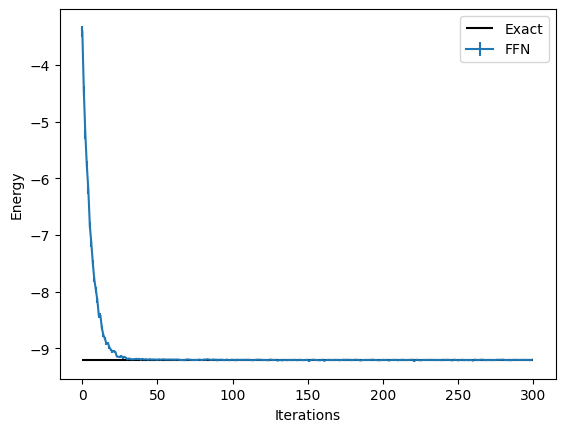

In [ ]:
data_FFN = log.data

from matplotlib import pyplot as plt

plt.errorbar(data_FFN["Energy"].iters, data_FFN["Energy"].Mean, yerr=data_FFN["Energy"].Sigma, label="FFN")
plt.hlines([E_gs], xmin=0, xmax=300, color='black', label="Exact")
plt.legend()

plt.xlabel('Iterations')
plt.ylabel('Energy')